# 🎯 ESCO Skill Retrieval Fine-tuning (v3.0 - Hybrid Approach)

This notebook fine-tunes `intfloat/multilingual-e5-base` for ESCO skill retrieval with **hybrid negative sampling strategy**.

## 📋 Setup Requirements:
1. **Upload Data**: Add your JSONL training files as a Kaggle dataset
    - Dataset includes a training file named r"*train*.jsonl" and optionally an evaluation file named r"*eval*.jsonl"
    - Dataset files contain data in the form {"query": <string>, "pos": <array<string>>, "neg": <array<string>>}
2. **Internet Access**: Turn on internet in Settings
3. **Enable GPU**: Settings → Accelerator → GPU T4 x2

### 🎯 **CachedMultipleNegativesRankingLoss**
- **Combines**: Curated hard negatives + dynamic in-batch negatives
- **Expertise**: Uses 3 carefully selected hard negatives per example (tricky skills we know the model struggles with)
- **Dynamic Sampling**: Adds 30-60 in-batch negatives that change every batch
- **Result**: Model learns to distinguish both curated challenges AND generalizes to unseen cases

### ⚙️ **Optimized Hyperparameters**
- **Warmup**: 15% → 10% (0.1 ratio, standard for fine-tuning)
- **Batch Size**: 16 → 32 (more in-batch negatives)
- **Gradient Accumulation**: 2 steps (effective batch = 64)
- **Hard Negatives**: 3 curated per example (subset of your 8 negatives)

## 🚀 Key Improvements:
- **E5 Optimized**: Proper `query:` and `passage:` prefixes
- **Hybrid Negatives**: Curated/Mined hard negatives + dynamic in-batch negatives
- **Reduced Overfitting Risk**: Reduced query exposure + shuffling + better loss
- **Early Stopping**: Training stops when metrics plateau
- **Comprehensive Metrics**: MRR@10, Recall@10, Precision@1, NDCG@10 tracking


## 🔧 Environment Setup

In [1]:
# 🚨 CRITICAL: Set environment variables FIRST to prevent widget hangs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['WANDB_DISABLED'] = 'true'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = 'true'
os.environ['JUPYTER_ENABLE_LAB'] = 'no'
os.environ['MPLBACKEND'] = 'Agg'  # Prevent matplotlib widgets

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Free space in kaggle output
#!rm -rf /kaggle/working/*

## 🔧 Setup run metadata and training arguments

In [3]:
# Metadata
from datetime import datetime
timestamp = datetime.now().strftime('%H%M%S')
# Run name used as model file name
run_name = f"esco_e5_finetuned_v3_{timestamp}"
# Training details string only used for readme creation.
training_details = "Uses CachedMultipleNegativesRankingLoss combining in-batch negatives with curated hard negatives. Random shuffling each epoch. Optimized for stable training and generalization. Training data contains human validated data, that was partly reduced to prevent overrepresentation of certain skills or split or compressed to decrease average query length. All esco skills as lables contain both label and description for more semantic depth and better blance in respect to average query length. Additionally more samples were synthetically generated to cover a broader and more balanced spectrum of the entire esco hierarchy."

# ⚙️ Training Configuration
CONFIG = {
    # 🎯 CORE TRAINING PARAMETERS
    'epochs': 5,               # 🔄 Reduced from 12 (less needed without triplet explosion)
    'batch_size': 32,          # 🚀 Increased from 16 (more in-batch negatives)
    'gradient_accumulation_steps': 2,  # 🔥 Effective batch = 64
    'learning_rate': 2e-5,     # 🐌 Standard for fine-tuning
    'warmup_ratio': 0.1,       # 🏃‍♂️ 10% warmup
    'save_steps': 50,         # 💾 Save checkpoints regularly
    'evaluation_steps': 50,   # 📏 Evaluate frequently
    
    # E5 Requirements
    'use_e5_prefixes': True,   # 🏷️ "query:" and "passage:" labels
    
    # 🔧 TRAINING STRATEGY
    'shuffle_data': True,      # 📊 Shuffle every epoch (no curriculum)
    'weight_decay': 0.01,      # 🍰 Standard weight decay
    
    # ⚖️ LOSS FUNCTION CONFIGURATION
    'use_cached_mnrl': True,   # 🎯 CachedMultipleNegativesRankingLoss (in-batch + hard negatives)
    'hard_negatives_per_sample': 3,  # 📌 Number of curated hard negatives to include
    'scale': 20.0,             # 📏 Temperature scaling for MNRL
    
    # 🎯 EVALUATION CONFIGURATION
    'eval_batch_size': 32,                # 🏃‍♂️ Eval batch size
    'primary_metric': 'recall@10',        # 🎯 Primary metric for model selection
    'early_stopping_metric': 'mrr@10',    # 🛑 Early stopping metric
    'early_stopping_patience': 1,         # 🕰️ Patience for early stopping
    'early_stopping_min_delta': 0.003,    # 📈 Minimum improvement threshold
    'save_best_model': True,              # 🏆 Keep the champion version
    
    # 📊 LOGGING & MONITORING
    'log_metrics_to_file': True,          # 💾 Save evaluation metrics to CSV
    'verbose_evaluation': True,           # 📢 Print detailed evaluation results
}

print("\n📊 Configuration parameters:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

# Calculate effective batch size and warmup
effective_batch = CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']
print(f"\n🔥 Training configuration:")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Gradient accumulation: {CONFIG['gradient_accumulation_steps']}")
print(f"   Effective batch size: {effective_batch}")
print(f"   Warmup ratio: {CONFIG['warmup_ratio']*100:.0f}%")

# Create output directory with better naming
from pathlib import Path
output_dir = Path(f"/kaggle/working/{run_name}")
output_dir.mkdir(exist_ok=True)
metrics_log_path = output_dir / 'evaluation_metrics.csv'



📊 Configuration parameters:
   epochs: 8
   batch_size: 32
   gradient_accumulation_steps: 2
   learning_rate: 2e-05
   warmup_ratio: 0.1
   save_steps: 50
   evaluation_steps: 50
   use_e5_prefixes: True
   shuffle_data: True
   weight_decay: 0.01
   use_cached_mnrl: True
   hard_negatives_per_sample: 3
   scale: 20.0
   eval_batch_size: 32
   primary_metric: recall@10
   early_stopping_metric: mrr@10
   early_stopping_patience: 1
   early_stopping_min_delta: 0.003
   save_best_model: True
   log_metrics_to_file: True
   verbose_evaluation: True

🔥 Training configuration:
   Batch size: 32
   Gradient accumulation: 2
   Effective batch size: 64
   Warmup ratio: 10%


## 📦 Package Installation

### Key Architecture Changes (v3.0):

**Old Approach (v2.0 - Unstable):**
- ❌ TripletLoss with fixed margin = 0.7
- ❌ 3 pos × 8 neg = 24 triplets per sample (48K total from 2K samples)
- ❌ No data shuffling (curriculum learning)
- ❌ 8 static pre-assigned negatives
- ❌ Result: Metrics peak at 0.68 then collapse to 0.52

**New Approach (v3.0 - Hybrid Strategy):**
- ✅ CachedMultipleNegativesRankingLoss (InfoNCE-style with hard negatives)
- ✅ 1 example per (query, pos, hard_negs) tuple
- ✅ Combines: Your curated hard negatives + dynamic in-batch negatives
- ✅ Random shuffling every epoch
- ✅ Expected: Steady improvement 0.45 → 0.58 → 0.71 → 0.78


In [4]:
# Install transformers and sentence-transformers
import subprocess
import sys

print("📦 Installing latest transformers and sentence-transformers...")

result1 = subprocess.run(
    [sys.executable, "-m", "pip", "install", "transformers==4.52.3", "-q", "--no-warn-script-location"],
    capture_output=True,
    text=True
)

result2 = subprocess.run(
    [sys.executable, "-m", "pip", "install", "sentence-transformers==5.1.1", "-q", "--no-warn-script-location"],
    capture_output=True,
    text=True
)

if result1.returncode == 0 and result2.returncode == 0:
    print("✅ Latest versions installed successfully!")
else:
    print(f"⚠️ Installation issues:")
    if result1.returncode != 0:
        print(f"   transformers: {result1.stderr[:100]}")
    if result2.returncode != 0:
        print(f"   sentence-transformers: {result2.stderr[:100]}")

# Import after installation
try:
    from sentence_transformers import SentenceTransformer, InputExample, losses
    from sentence_transformers.trainer import SentenceTransformerTrainer
    from torch.utils.data import DataLoader
    import json
    from pathlib import Path
    from datetime import datetime
    import zipfile
    import numpy as np
    import torch
    print("✅ All imports successful!")
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("🔄 Try restarting the kernel and running again")

📦 Installing latest transformers and sentence-transformers...
✅ Latest versions installed successfully!


E0000 00:00:1759955393.120673      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759955393.174148      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All imports successful!


In [6]:
# 🖥️ Check GPU availability
import torch
import os

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Available: {gpu_name}")
    print(f"💾 Total VRAM: {gpu_memory:.1f} GB")
    
    # Check available memory
    allocated = torch.cuda.memory_allocated() / 1e9
    available = gpu_memory - allocated
    print(f"📊 Currently allocated: {allocated:.1f} GB")
    print(f"🆓 Available for training: {available:.1f} GB")
else:
    print("❌ NO GPU DETECTED!")
    print("🔧 Go to Settings → Accelerator → GPU T4 x2")

✅ GPU Available: Tesla T4
💾 Total VRAM: 15.8 GB
📊 Currently allocated: 0.0 GB
🆓 Available for training: 15.8 GB


## 📂 Data Loading & Preparation

In [7]:
# 🔍 Find training data in Kaggle input
def find_training_data():
    input_dir = Path("/kaggle/input")
    
    print(f"🔍 Searching in: {input_dir}")
    
    train_file = None
    eval_file = None
    
    # List all available datasets
    if input_dir.exists():
        datasets = list(input_dir.iterdir())
        print(f"📊 Available datasets: {[d.name for d in datasets if d.is_dir()]}")
    
    # Search for JSONL files
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.jsonl'):
                file_path = Path(root) / file
                print(f"   📄 Found: {file_path}")
                
                if 'train' in file.lower() and not train_file:
                    train_file = file_path
                elif 'eval' in file.lower() and not eval_file:
                    eval_file = file_path
    
    return train_file, eval_file

train_file, eval_file = find_training_data()

if train_file:
    print(f"✅ Training data: {train_file}")
    if eval_file:
        print(f"✅ Eval data: {eval_file}")
    else:
        print("❌ No evaluation data found. Evaluator will be disabled during training.")
else:
    print("❌ No training data found!")
    print("📋 Please upload your JSONL files as a Kaggle dataset")

🔍 Searching in: /kaggle/input
📊 Available datasets: ['course-esco-skill-retrieval']
   📄 Found: /kaggle/input/course-esco-skill-retrieval/eval_dataset.jsonl
   📄 Found: /kaggle/input/course-esco-skill-retrieval/train_dataset.jsonl
✅ Training data: /kaggle/input/course-esco-skill-retrieval/train_dataset.jsonl
✅ Eval data: /kaggle/input/course-esco-skill-retrieval/eval_dataset.jsonl


In [8]:
# 📂 Load training data
def load_jsonl(file_path):
    """Load JSONL data with progress info."""
    data = []
    
    print(f"📂 Loading: {file_path.name}")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            line = line.strip()
            if line:
                try:
                    sample = json.loads(line)
                    data.append(sample)
                    
                    # Show examples
                    if i < 3:  # Show first 3 examples
                        query_len = len(sample.get('query', ''))
                        pos_count = len(sample.get('pos', []))
                        neg_count = len(sample.get('neg', []))
                        print(f"   Example {i+1}: {query_len} chars, {pos_count} pos, {neg_count} neg")
                        
                except json.JSONDecodeError:
                    continue
    
    print(f"✅ Loaded {len(data)} samples")
    return data

# Load the data
if train_file:
    train_data = load_jsonl(train_file)
    print(f"\n📊 Training samples: {len(train_data)}")
else:
    print("❌ Cannot proceed without training data!")
    train_data = []

📂 Loading: train_dataset.jsonl
   Example 1: 294 chars, 1 pos, 10 neg
   Example 2: 180 chars, 1 pos, 10 neg
   Example 3: 292 chars, 1 pos, 10 neg
✅ Loaded 6354 samples

📊 Training samples: 6354


In [9]:
from typing import List, Dict
import random

# 📝 Create training examples with hard negatives + in-batch negatives
def create_training_examples(data: List[Dict], config: Dict):
    """Create training examples for CachedMultipleNegativesRankingLoss.
    Changes:
    1. No curriculum learning - just shuffle randomly to prevent overfitting
    2. Loss function adds in-batch negatives automatically
        - Before with TripletLoss the model only saw the same 8 hard negatives every epoch
        - Now batch_size * gradient_acummulation ((32*2) -1 = 63) steps negatives are used per sample, diffrent each epoch
    3. Include curated hard negatives (not all, just a few)
    4. Best of both worlds: premined hard negatives + dynamic negatives
    """
    from sentence_transformers import InputExample
    
    print("🎯 Creating training examples (v3.0 - hybrid approach)...")
    print(f"   Strategy: Curated hard negatives + in-batch negatives")
    
    # Shuffle data for random order
    if config.get('shuffle_data', True):
        random.shuffle(data)
        print("   🔀 Data shuffled randomly")
    
    examples = []
    hard_negatives_per_sample = config.get('hard_negatives_per_sample', 3)
    
    for sample in data:
        query = sample.get('query', '').strip()
        pos_labels = sample.get('pos', [])
        neg_labels = sample.get('neg', [])
        
        if not query or not pos_labels:
            continue
        
        # E5 format: add prefixes
        if config['use_e5_prefixes']:
            query_text = f"query: {query}"
        else:
            query_text = query
        
        # Select a subset of hard negatives
        # These are curated "tricky" skills the model should learn to distinguish
        selected_hard_negs = []
        if neg_labels and hard_negatives_per_sample > 0:
            # Randomly sample hard negatives to get variety across epochs
            num_to_select = min(hard_negatives_per_sample, len(neg_labels))
            selected_hard_negs = random.sample(neg_labels, num_to_select)
            
            if config['use_e5_prefixes']:
                selected_hard_negs = [f"passage: {neg.strip()}" for neg in selected_hard_negs if neg.strip()]
            else:
                selected_hard_negs = [neg.strip() for neg in selected_hard_negs if neg.strip()]
        
        # Create examples: (query, positive, [hard_negatives])
        # The loss function will add in-batch negatives on top of these
        for pos in pos_labels:
            pos = pos.strip()
            if not pos:
                continue
                
            if config['use_e5_prefixes']:
                pos_text = f"passage: {pos}"
            else:
                pos_text = pos
            
            # Create triplet: (query, positive, hard_negatives)
            if selected_hard_negs:
                examples.append(InputExample(texts=[query_text, pos_text] + selected_hard_negs))
            else:
                # Fallback: just (query, positive) if no hard negatives available
                examples.append(InputExample(texts=[query_text, pos_text]))
    
    return examples

# Create examples
if train_data:
    print(f"\n📊 Original samples: {len(train_data)}")
    examples = create_training_examples(train_data, CONFIG)
    print(f"✅ Total training examples: {len(examples):,}")
    
    # Calculate query exposure
    avg_pos_per_query = len(examples) / len(train_data) if train_data else 0
    print(f"📊 Average examples per query: {avg_pos_per_query:.1f}x")
    
    # Analyze hard negatives usage
    examples_with_hard_negs = sum(1 for ex in examples if len(ex.texts) > 2)
    avg_hard_negs = sum(len(ex.texts) - 2 for ex in examples) / len(examples) if examples else 0
    
    print(f"\n✅ Hybrid negative sampling approach statistics:")
    print(f"   🎯 Using CachedMultipleNegativesRankingLoss")
    print(f"   📊 Examples with hard negatives: {examples_with_hard_negs:,} ({examples_with_hard_negs/len(examples)*100:.1f}%)")
    print(f"   📌 Avg curated hard negatives per example: {avg_hard_negs:.1f}")
    print(f"   🔄 Additional in-batch negatives: ~{CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps'] - 1 - avg_hard_negs} per query")
    print(f"   📊 Total negatives per query: ~{avg_hard_negs + CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps'] - 1 - avg_hard_negs:.0f}")
    print(f"   🎲 Random shuffling: Enabled for each epoch")
    print(f"   💡 Query exposure: {avg_pos_per_query:.1f}x per epoch (was 24x in v2.0 with tripletloss)")
else:
    examples = []



📊 Original samples: 6354
🎯 Creating training examples (v3.0 - hybrid approach)...
   Strategy: Curated hard negatives + in-batch negatives
   🔀 Data shuffled randomly
✅ Total training examples: 9,562
📊 Average examples per query: 1.5x

✅ Hybrid negative sampling approach statistics:
   🎯 Using CachedMultipleNegativesRankingLoss
   📊 Examples with hard negatives: 9,562 (100.0%)
   📌 Avg curated hard negatives per example: 3.0
   🔄 Additional in-batch negatives: ~60.0 per query
   📊 Total negatives per query: ~63
   🎲 Random shuffling: Enabled for each epoch
   💡 Query exposure: 1.5x per epoch (was 24x in v2.0 with tripletloss)


## 🤖 Model Loading & Training Setup

In [10]:
# 🤖 Load and Optimize Model Architecture
MODEL_NAME = 'intfloat/multilingual-e5-base'

print(f"🤖 Loading model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)

model.max_seq_length = 512

# Enable memory optimizations
if torch.cuda.is_available():
    # Print memory usage
    allocated = torch.cuda.memory_allocated() / 1e9
    total = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"💾 GPU Memory after model loading: {allocated:.1f}GB / {total:.1f}GB")

print(f"✅ Model ready: {model.device}, {model.max_seq_length} tokens")
print(f"   📊 Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   🎯 Optimized for: precision-focused asymmetric retrieval")

🤖 Loading model: intfloat/multilingual-e5-base
💾 GPU Memory after model loading: 1.1GB / 15.8GB
✅ Model ready: cuda:0, 512 tokens
   📊 Parameters: 278,043,648
   🎯 Optimized for: precision-focused asymmetric retrieval


In [11]:
# 🔧 FIXED: Custom early stopping callback with proper evaluation integration

def resolve_metric_key(metrics, target):
    """Find the best matching key in metrics for the requested target metric.
    Strategy: exact match -> endswith (case-insensitive) -> contains (case-insensitive)
    Returns the selected key or None.
    """
    if metrics is None:
        return None
    target_lower = target.lower()
    # If metrics is a dict-like
    try:
        keys = list(metrics.keys())
    except Exception:
        # Not dict-like
        return None

    # 1) exact key
    if target in metrics:
        return target

    # 2) endswith
    for k in keys:
        try:
            if k.lower().endswith(target_lower):
                return k
        except Exception:
            continue

    # 3) contains
    for k in keys:
        try:
            if target_lower in k.lower():
                return k
        except Exception:
            continue

    return None


def get_metric_value(metrics, target):
    """Return (key, value) for a target metric name from metrics dict-like, or (None, None)."""
    sel = resolve_metric_key(metrics, target)
    if sel is None:
        return None, None
    return sel, metrics.get(sel)


class EarlyStoppingCallback:
    """
    Enhanced early stopping implementation that properly tracks evaluation metrics.
    """
    def __init__(self, patience=3, min_delta=0.005, metric='mrr@10', mode='max', log_file=None, min_evaluations=0):
        self.patience = patience
        self.min_delta = min_delta
        self.metric = metric
        self.mode = mode
        self.best_score = float('-inf') if mode == 'max' else float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        self.should_stop = False
        self.log_file = log_file
        self.evaluation_history = []
        self.min_evaluations = min_evaluations
        self.evaluation_count = 0
        
    def log_metric(self, epoch, step, metrics):
        """Log evaluation metrics to file and console.
        This method is robust to evaluators that prefix metric names (e.g. "esco_curriculum_cosine_mrr@10").
        Lookup strategy:
         1. exact key match
         2. key that endswith target metric (case-insensitive)
         3. key that contains target metric (fallback)
        """
        import csv
        from pathlib import Path

        # Prepare
        metric_value = None
        selected_key = None
        target_lower = self.metric.lower()

        # 1) Direct key
        if self.metric in metrics:
            selected_key = self.metric
            metric_value = metrics[selected_key]
        else:
            # 2) Keys that end with the target metric (preferred)
            for k, v in metrics.items():
                try:
                    if k.lower().endswith(target_lower):
                        selected_key = k
                        metric_value = v
                        break
                except Exception:
                    continue

        # 3) Fallback: keys that contain the metric name anywhere
        if metric_value is None:
            for k, v in metrics.items():
                try:
                    if target_lower in k.lower():
                        selected_key = k
                        metric_value = v
                        break
                except Exception:
                    continue

        if metric_value is None:
            print(f"   ⚠️ Metric '{self.metric}' not found in evaluation results")
            print(f"   📊 Available metrics: {list(metrics.keys())}")
            return None
        else:
            if selected_key != self.metric:
                print(f"   🔎 Using metric key '{selected_key}' for target '{self.metric}'")

        # Store in history
        eval_record = {
            'epoch': epoch,
            'step': step,
            **{k: (float(v) if isinstance(v, (int, float)) else v) for k, v in metrics.items()}
        }
        self.evaluation_history.append(eval_record)
        
        # Log to file
        if self.log_file:
            file_path = Path(self.log_file)
            write_header = not file_path.exists()

            with open(file_path, 'a', newline='') as f:
                if write_header:
                    writer = csv.DictWriter(f, fieldnames=eval_record.keys())
                    writer.writeheader()
                else:
                    writer = csv.DictWriter(f, fieldnames=eval_record.keys())
                writer.writerow(eval_record)

        # Print detailed evaluation results (use robust lookups)
        print(f"\n   📊 Evaluation at step {step} (epoch {epoch}):")
        print(f"      🎯 {selected_key}: {metric_value:.4f}")

        # robustly print recall@10, precision@1, ndcg@10 if present under any prefixed key
        for t, label in [('recall@10', 'Recall@10'), ('precision@1', 'Precision@1'), ('ndcg@10', 'NDCG@10')]:
            k, v = get_metric_value(metrics, t)
            if v is not None:
                try:
                    print(f"      {label}: {v:.4f}")
                except Exception:
                    print(f"      {label}: {v}")

        return metric_value
        
    def __call__(self, score, epoch, step=None):
        """Check if training should stop based on the score."""
        self.evaluation_count += 1
        
        if self.mode == 'max':
            improved = score > (self.best_score + self.min_delta)
        else:
            improved = score < (self.best_score - self.min_delta)
            
        if improved:
            self.best_score = score
            self.wait = 0
            print(f"   ✅ NEW BEST {self.metric}: {score:.4f} (improvement: +{score - self.best_score + self.min_delta:.4f})")
        else:
            self.wait += 1
            print(f"   ⏳ No improvement for {self.wait}/{self.patience} evaluations")
            print(f"      Current: {score:.4f}, Best: {self.best_score:.4f} (delta: {score - self.best_score:.4f})")
        
        # Check if we've met minimum evaluations requirement
        if self.evaluation_count < self.min_evaluations:
            print(f"   🚫 Early stopping disabled (evaluation {self.evaluation_count}/{self.min_evaluations}) - curriculum learning warmup")
            return False
            
        if self.wait >= self.patience:
            self.stopped_epoch = epoch
            self.should_stop = True
            print(f"\n   🛑 EARLY STOPPING TRIGGERED!")
            print(f"      Stopped at epoch {epoch}, step {step}")
            print(f"      Best {self.metric}: {self.best_score:.4f}")
            print(f"      No improvement for {self.patience} consecutive evaluations")
            
        return self.should_stop


# Evaluator wrapper to integrate early stopping
class EvaluatorWithCallback:
    """Wrapper that runs evaluator and calls early stopping callback."""
    
    def __init__(self, evaluator, early_stopping_callback, epoch_tracker):
        self.evaluator = evaluator
        self.callback = early_stopping_callback
        self.epoch_tracker = epoch_tracker
        self.step_count = 0
        
    def __call__(self, model, output_path=None, epoch=-1, steps=-1):
        """Run evaluation and check early stopping."""
        
        # Run the actual evaluation
        metrics = self.evaluator(model, output_path, epoch, steps)
        
        self.step_count = steps
        
        # Extract metrics from the evaluation results
        if hasattr(metrics, '__dict__'):
            metrics_dict = vars(metrics)
        elif isinstance(metrics, dict):
            metrics_dict = metrics
        else:
            # If evaluator returns a score directly
            metrics_dict = {self.callback.metric: metrics}
        
        # Log metrics
        target_score = self.callback.log_metric(
            epoch=self.epoch_tracker['current_epoch'],
            step=steps,
            metrics=metrics_dict
        )
        
        # Check early stopping
        if target_score is not None:
            should_stop = self.callback(
                score=target_score,
                epoch=self.epoch_tracker['current_epoch'],
                step=steps
            )
            
            if should_stop:
                self.epoch_tracker['should_stop'] = True
        
        return metrics

# Enhanced evaluator with better metrics for few-positive scenarios
def create_enhanced_evaluator(eval_data: List[Dict], config: Dict):
    """Create evaluator optimized for datasets with few positive labels per query."""
    from sentence_transformers.evaluation import InformationRetrievalEvaluator
    
    if not eval_data:
        return None
    
    print("📊 Creating enhanced evaluator for few-positive scenarios...")

    queries = {}
    corpus = {}
    relevant_docs = {}
    corpus_id = 0
    label_to_id = {}
    
    # Analyze the positive label distribution
    positive_counts = []
    
    for i, sample in enumerate(eval_data):
        query = sample.get('query', '').strip()
        pos_labels = sample.get('pos', [])
        neg_labels = sample.get('neg', [])
        
        if not query or not pos_labels:
            continue

        positive_counts.append(len(pos_labels))
        
        query_id = f"q_{i}"
        queries[query_id] = f"query: {query}" if config['use_e5_prefixes'] else query
        relevant_docs[query_id] = set()
        
        # Add all labels to corpus
        for label in pos_labels + neg_labels:
            label = label.strip()
            if label and label not in label_to_id:
                label_to_id[label] = f"doc_{corpus_id}"
                corpus[f"doc_{corpus_id}"] = f"passage: {label}" if config['use_e5_prefixes'] else label
                corpus_id += 1
        
        # Mark positives as relevant
        for pos_label in pos_labels:
            pos_label = pos_label.strip()
            if pos_label in label_to_id:
                relevant_docs[query_id].add(label_to_id[pos_label])
        
        relevant_docs[query_id] = list(relevant_docs[query_id])
    
    # Print analysis
    avg_positives = sum(positive_counts) / len(positive_counts) if positive_counts else 0
    max_positives = max(positive_counts) if positive_counts else 0
    min_positives = min(positive_counts) if positive_counts else 0
    
    print(f"   📝 Evaluation set analysis:")
    print(f"      Queries: {len(queries):,}, Skills: {len(corpus):,}")
    print(f"      Positives per query: avg={avg_positives:.1f}, min={min_positives}, max={max_positives}")
    print(f"   📊 Key metrics: MRR@10 (ranking), Recall@10 (coverage), P@1 (top result)")
    
    return InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus, 
        relevant_docs=relevant_docs,
        name='esco_curriculum',
        show_progress_bar=True,
        batch_size=config['eval_batch_size'],
        precision_recall_at_k=[1, 3, 5, 10],
        ndcg_at_k=[5, 10],
        mrr_at_k=[10],
    )


In [12]:
# 🎯 Initialize Evaluator and Early Stopping
print("🎯 Initializing evaluation and early stopping...")

# Load evaluation data if available
eval_data = []
if eval_file:
    print(f"📂 Loading evaluation data from: {eval_file}")
    eval_data = load_jsonl(eval_file)
    print(f"✅ Loaded {len(eval_data)} evaluation samples")
else:
    print("⚠️ No evaluation file found - early stopping will be disabled")

# Create evaluator if we have eval data
evaluator = None
if eval_data:
    evaluator = create_enhanced_evaluator(eval_data, CONFIG)
    
if evaluator:
    print("✅ Evaluator created successfully")
    
    # Create early stopping callback (no min evaluations needed without curriculum)
    early_stopping = EarlyStoppingCallback(
        patience=CONFIG['early_stopping_patience'],
        min_delta=CONFIG['early_stopping_min_delta'],
        metric=CONFIG['early_stopping_metric'],
        mode='max',
        log_file=str(metrics_log_path),
        min_evaluations=0  # No curriculum learning, so can stop anytime
    )
    print(f"✅ Early stopping initialized:")
    print(f"   Metric: {CONFIG['early_stopping_metric']}")
    print(f"   Patience: {CONFIG['early_stopping_patience']}")
    
    # Create epoch tracker (shared state between evaluator and callback)
    epoch_tracker = {
        'current_epoch': 0,
        'should_stop': False
    }
    
    # Wrap evaluator with early stopping
    evaluator_with_callback = EvaluatorWithCallback(
        evaluator=evaluator,
        early_stopping_callback=early_stopping,
        epoch_tracker=epoch_tracker
    )
    print("✅ Evaluator wrapped with early stopping callback")
    
else:
    print("⚠️ Evaluator not available - training will proceed without early stopping")
    evaluator_with_callback = None
    early_stopping = None
    epoch_tracker = None

print("\n" + "=" * 60)


🎯 Initializing evaluation and early stopping...
📂 Loading evaluation data from: /kaggle/input/course-esco-skill-retrieval/eval_dataset.jsonl
📂 Loading: eval_dataset.jsonl
   Example 1: 289 chars, 1 pos, 2 neg
   Example 2: 439 chars, 3 pos, 18 neg
   Example 3: 206 chars, 1 pos, 2 neg
✅ Loaded 529 samples
✅ Loaded 529 evaluation samples
📊 Creating enhanced evaluator for few-positive scenarios...
   📝 Evaluation set analysis:
      Queries: 529, Skills: 1,459
      Positives per query: avg=1.5, min=1, max=13
   📊 Key metrics: MRR@10 (ranking), Recall@10 (coverage), P@1 (top result)
✅ Evaluator created successfully
✅ Early stopping initialized:
   Metric: mrr@10
   Patience: 1
✅ Evaluator wrapped with early stopping callback



## 🏋️ Training Execution

In [ ]:
import time
from sentence_transformers import losses, util

if examples and len(examples) > 0:
    print("🚀 Starting Training with CachedMultipleNegativesRankingLoss (v3.0)")
    print("=" * 70)
    
    start_time = time.time()
    
    # Check for existing checkpoints to resume from
    checkpoint_dirs = list(output_dir.glob('checkpoint-*'))
    resume_from_checkpoint = None
    if checkpoint_dirs:
        # Sort by checkpoint number and get the latest
        checkpoint_dirs.sort(key=lambda x: int(x.name.split('-')[1]))
        resume_from_checkpoint = str(checkpoint_dirs[-1])
        print(f"📂 Found existing checkpoint: {checkpoint_dirs[-1].name}")
        print(f"🔄 Will resume training from this checkpoint")
    else:
        print(f"📂 No existing checkpoints found - starting fresh training")
    
    # Setup loss function - CachedMultipleNegativesRankingLoss for hybrid approach
    if CONFIG.get('use_cached_mnrl', True):
        # OPTION 1: CachedMultipleNegativesRankingLoss
        # Uses both your hard negatives AND in-batch negatives
        train_loss = losses.CachedMultipleNegativesRankingLoss(
            model=model, 
            scale=CONFIG.get('scale', 20.0),
            similarity_fct=util.cos_sim
        )
        
        print(f"\n🎯 Using CachedMultipleNegativesRankingLoss (Hybrid Approach)")
        print(f"   📌 Curated hard negatives: {CONFIG.get('hard_negatives_per_sample', 3)} per example")
        print(f"   🔄 In-batch negatives: All other positives in batch")
        print(f"   📏 Scale (temperature): {CONFIG.get('scale', 20.0)}")
        print(f"   💡 Best of both worlds: Your expertise + dynamic sampling")
    else:
        # OPTION 2: Standard MultipleNegativesRankingLoss (fallback)
        train_loss = losses.MultipleNegativesRankingLoss(
            model=model, 
            scale=CONFIG.get('scale', 20.0),
            similarity_fct=util.cos_sim
        )
        print(f"\n🎯 Using MultipleNegativesRankingLoss (In-batch only)")
        print(f"   🔄 In-batch negatives: All other positives in batch")
        print(f"   📏 Scale (temperature): {CONFIG.get('scale', 20.0)}")

    # Calculate training statistics
    from datasets import Dataset as HFDataset
    
    # Convert InputExample to dictionaries for HuggingFace Dataset
    dataset_dicts = []
    for ex in examples:
        example_dict = {
            'anchor': ex.texts[0],      # query
            'positive': ex.texts[1],    # positive skill
        }
        
        # Add hard negatives - CachedMNRL expects 'negative' field for ALL samples
        # Use empty list if no hard negatives available
        if len(ex.texts) > 2:
            example_dict['negative'] = ex.texts[2:]
        else:
            example_dict['negative'] = []  # Empty list for samples without hard negatives
        
        dataset_dicts.append(example_dict)
    
    # Create HuggingFace Dataset
    hf_dataset = HFDataset.from_list(dataset_dicts)
    print(f"\n✅ Created dataset with {len(examples):,} examples")
    
    # Calculate steps
    steps_per_epoch = len(examples) // (CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps'])
    total_steps = steps_per_epoch * CONFIG['epochs']
    warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
    
    print(f"\n📊 Training plan:")
    print(f"   Examples: {len(examples):,}")
    print(f"   Batch size: {CONFIG['batch_size']}")
    print(f"   Gradient accumulation: {CONFIG['gradient_accumulation_steps']}")
    print(f"   Effective batch: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
    print(f"   Steps per epoch: {steps_per_epoch:,}")
    print(f"   Total epochs: {CONFIG['epochs']}")
    print(f"   Total steps: {total_steps:,}")
    print(f"   Warmup steps: {warmup_steps} ({CONFIG['warmup_ratio']*100:.0f}%)")
    print(f"   Evaluation every: {CONFIG['evaluation_steps']} steps")

    print(f"\n🎯 Training with early stopping:")
    print(f"   📏 Evaluation every {CONFIG['evaluation_steps']} steps")
    print(f"   🛑 Early stopping metric: {CONFIG['early_stopping_metric']}")
    print(f"   🕰️ Patience: {CONFIG['early_stopping_patience']} evaluations")
    print(f"   📈 Min improvement: {CONFIG['early_stopping_min_delta']}")
    print(f"   💾 Logging metrics to: {metrics_log_path}")
    
    # Setup training with SentenceTransformerTrainer
    from sentence_transformers import SentenceTransformerTrainingArguments
    from sentence_transformers.trainer import SentenceTransformerTrainer
    from transformers import TrainerCallback
    
    # Create a custom callback that checks early stopping after evaluation
    class EarlyStoppingTrainerCallback(TrainerCallback):
        """Custom callback that integrates evaluation and early stopping."""
        
        def __init__(self, early_stopping, evaluator_with_callback, epoch_tracker):
            super().__init__()
            self.early_stopping = early_stopping
            self.evaluator_with_callback = evaluator_with_callback
            self.epoch_tracker = epoch_tracker
            self.global_step = 0
            self.best_model_path = None
            
        def on_step_end(self, args, state, control, **kwargs):
            """Called at the end of each training step."""
            self.global_step = state.global_step
            
            # Check if evaluation should happen
            if state.global_step % CONFIG['evaluation_steps'] == 0:
                print(f"\n⏸️  Evaluating at step {state.global_step}...")
                
                # Run evaluation with our wrapper
                model = kwargs.get('model')
                if model:
                    self.evaluator_with_callback(
                        model, 
                        str(output_dir), 
                        epoch=self.epoch_tracker['current_epoch'],
                        steps=state.global_step
                    )
                    
                    # Save model if it's the best so far
                    if self.early_stopping.wait == 0:  # This means we just got a new best score
                        self.best_model_path = output_dir / f'best_model'
                        model.save(str(self.best_model_path))
                        print(f"   💾 Saved new best model to: {self.best_model_path}")
                    
                    # Check if early stopping triggered
                    if self.epoch_tracker['should_stop']:
                        print(f"\n🛑 Early stopping activated! Stopping training.")
                        control.should_training_stop = True
            
            return control
        
        def on_epoch_end(self, args, state, control, **kwargs):
            """Called at the end of each epoch."""
            self.epoch_tracker['current_epoch'] += 1
            
            # Check early stopping at epoch end too
            if self.epoch_tracker['should_stop']:
                print(f"\n🛑 Training stopped early at epoch {self.epoch_tracker['current_epoch']}")
                control.should_training_stop = True
                
            return control
    
    # Setup training arguments
    training_args = SentenceTransformerTrainingArguments(
        output_dir=str(output_dir),
        num_train_epochs=CONFIG['epochs'],
        per_device_train_batch_size=CONFIG['batch_size'],
        gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
        learning_rate=CONFIG['learning_rate'],
        warmup_ratio=CONFIG['warmup_ratio'],
        lr_scheduler_type='cosine',
        weight_decay=CONFIG['weight_decay'],
        logging_steps=50,
        save_steps=CONFIG['save_steps'],
        save_total_limit=1,
        save_only_model=True,
        fp16=torch.cuda.is_available(),
        logging_dir=str(output_dir / 'logs'),
        dataloader_drop_last=False,  # Don't drop last batch
        dataloader_num_workers=0,    # No multiprocessing for stability
    )
    
    print(f"\n📉 Learning rate schedule: cosine decay with {CONFIG['warmup_ratio']*100:.0f}% warmup")
    print(f"💾 Storage optimization: save_total_limit=1, save_only_model=True")
    if resume_from_checkpoint:
        print(f"🔄 Resume from checkpoint: {Path(resume_from_checkpoint).name}")
    
    # Create trainer with callback
    trainer_callback = EarlyStoppingTrainerCallback(
        early_stopping=early_stopping,
        evaluator_with_callback=evaluator_with_callback,
        epoch_tracker=epoch_tracker
    )
    
    trainer = SentenceTransformerTrainer(
        model=model,
        args=training_args,
        train_dataset=hf_dataset,
        loss=train_loss,
        callbacks=[trainer_callback]
    )
    
    # Train the model (with checkpoint resumption if available)
    print("\n🚀 Starting training with hybrid approach...")
    print("=" * 70)
    trainer.train(resume_from_checkpoint=resume_from_checkpoint)
    
    # Load the best model if it was saved
    if trainer_callback.best_model_path and trainer_callback.best_model_path.exists():
        print(f"\n🏆 Loading best model from: {trainer_callback.best_model_path}")
        model = SentenceTransformer(str(trainer_callback.best_model_path))
        # Save it to the main output directory
        model.save(str(output_dir))
        print(f"✅ Best model saved to: {output_dir}")
    
    if early_stopping and early_stopping.best_score > float('-inf'):
        print(f"🏆 Best {CONFIG['early_stopping_metric']}: {early_stopping.best_score:.4f}")
    
    training_time = time.time() - start_time
    print("\n" + "=" * 70)
    print("🎉 TRAINING COMPLETED!")
    print(f"⏱️ Time: {training_time/60:.1f} minutes")
    
    if early_stopping and early_stopping.should_stop:
        print(f"🛑 Early stopping triggered at epoch {early_stopping.stopped_epoch + 1}")
        print(f"🎯 Best {CONFIG['early_stopping_metric']}: {early_stopping.best_score:.4f}")
    else:
        print(f"✅ Completed all {CONFIG['epochs']} epochs")
    
    print(f"📊 Evaluation metrics logged to: {metrics_log_path}")
    
    # Save comprehensive training log
    training_log = {
        'version': 'v3.0-hybrid',
        'config': CONFIG,
        'training_time_minutes': (time.time() - start_time) / 60,
        'total_examples': len(examples),
        'examples_per_sample': len(examples) / len(train_data) if train_data else 0,
        'model_name': MODEL_NAME,
        'timestamp': timestamp,
        'loss_function': 'CachedMultipleNegativesRankingLoss' if CONFIG.get('use_cached_mnrl') else 'MultipleNegativesRankingLoss',
        'loss_scale': CONFIG.get('scale', 20.0),
        'hard_negatives_per_sample': CONFIG.get('hard_negatives_per_sample', 0),
        'lr_scheduler': 'cosine',
        'warmup_steps': warmup_steps,
        'total_steps': total_steps,
        'resumed_from_checkpoint': resume_from_checkpoint is not None,
        'checkpoint_path': resume_from_checkpoint if resume_from_checkpoint else None,
        'early_stopping_used': evaluator_with_callback is not None,
        'early_stopping_triggered': early_stopping.should_stop if early_stopping else False,
        'best_metric_score': early_stopping.best_score if early_stopping else None,
        'stopped_epoch': early_stopping.stopped_epoch if early_stopping and early_stopping.should_stop else None,
        'total_evaluations': len(early_stopping.evaluation_history) if early_stopping else 0
    }
    
    import json
    with open(output_dir / 'training_log.json', 'w') as f:
        json.dump(training_log, f, indent=2)
    
    print(f"📋 Training log saved: {output_dir / 'training_log.json'}")
        
else:
    print("❌ No training examples available!")


🚀 Starting Training with CachedMultipleNegativesRankingLoss (v3.0)
📂 No existing checkpoints found - starting fresh training

🎯 Using CachedMultipleNegativesRankingLoss (Hybrid Approach)
   📌 Curated hard negatives: 3 per example
   🔄 In-batch negatives: All other positives in batch
   📏 Scale (temperature): 20.0
   💡 Best of both worlds: Your expertise + dynamic sampling

✅ Created dataset with 9,562 examples

📊 Training plan:
   Examples: 9,562
   Batch size: 32
   Gradient accumulation: 2
   Effective batch: 64
   Steps per epoch: 149
   Total epochs: 8
   Total steps: 1,192
   Warmup steps: 119 (10%)
   Evaluation every: 50 steps

🎯 Training with early stopping:
   📏 Evaluation every 50 steps
   🛑 Early stopping metric: mrr@10
   🕰️ Patience: 1 evaluations
   📈 Min improvement: 0.003
   💾 Logging metrics to: /kaggle/working/esco_e5_finetuned_v3_202759/evaluation_metrics.csv


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



📉 Learning rate schedule: cosine decay with 10% warmup
💾 Storage optimization: save_total_limit=1, save_only_model=True


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]


🚀 Starting training with hybrid approach...


Step,Training Loss
50,4.287000
100,0.788200
150,0.642700
200,0.497400
250,0.409900
300,0.396900
350,0.326000



⏸️  Evaluating at step 50...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


   🔎 Using metric key 'esco_curriculum_cosine_mrr@10' for target 'mrr@10'

   📊 Evaluation at step 50 (epoch 0):
      🎯 esco_curriculum_cosine_mrr@10: 0.8421
      Recall@10: 0.9236
      Precision@1: 0.7732
      NDCG@10: 0.8414
   ✅ NEW BEST mrr@10: 0.8421 (improvement: +0.0030)
   💾 Saved new best model to: /kaggle/working/esco_e5_finetuned_v3_202759/best_model

⏸️  Evaluating at step 100...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


   🔎 Using metric key 'esco_curriculum_cosine_mrr@10' for target 'mrr@10'

   📊 Evaluation at step 100 (epoch 1):
      🎯 esco_curriculum_cosine_mrr@10: 0.8809
      Recall@10: 0.9539
      Precision@1: 0.8147
      NDCG@10: 0.8823
   ✅ NEW BEST mrr@10: 0.8809 (improvement: +0.0030)
   💾 Saved new best model to: /kaggle/working/esco_e5_finetuned_v3_202759/best_model

⏸️  Evaluating at step 150...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.78s/it]


   🔎 Using metric key 'esco_curriculum_cosine_mrr@10' for target 'mrr@10'

   📊 Evaluation at step 150 (epoch 1):
      🎯 esco_curriculum_cosine_mrr@10: 0.8954
      Recall@10: 0.9618
      Precision@1: 0.8374
      NDCG@10: 0.8970
   ✅ NEW BEST mrr@10: 0.8954 (improvement: +0.0030)
   💾 Saved new best model to: /kaggle/working/esco_e5_finetuned_v3_202759/best_model

⏸️  Evaluating at step 200...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


   🔎 Using metric key 'esco_curriculum_cosine_mrr@10' for target 'mrr@10'

   📊 Evaluation at step 200 (epoch 2):
      🎯 esco_curriculum_cosine_mrr@10: 0.8987
      Recall@10: 0.9604
      Precision@1: 0.8431
      NDCG@10: 0.8960
   ✅ NEW BEST mrr@10: 0.8987 (improvement: +0.0030)
   💾 Saved new best model to: /kaggle/working/esco_e5_finetuned_v3_202759/best_model

⏸️  Evaluating at step 250...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


   🔎 Using metric key 'esco_curriculum_cosine_mrr@10' for target 'mrr@10'

   📊 Evaluation at step 250 (epoch 3):
      🎯 esco_curriculum_cosine_mrr@10: 0.9027
      Recall@10: 0.9589
      Precision@1: 0.8507
      NDCG@10: 0.8987
   ✅ NEW BEST mrr@10: 0.9027 (improvement: +0.0030)
   💾 Saved new best model to: /kaggle/working/esco_e5_finetuned_v3_202759/best_model

⏸️  Evaluating at step 300...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


   🔎 Using metric key 'esco_curriculum_cosine_mrr@10' for target 'mrr@10'

   📊 Evaluation at step 300 (epoch 3):
      🎯 esco_curriculum_cosine_mrr@10: 0.9092
      Recall@10: 0.9639
      Precision@1: 0.8582
      NDCG@10: 0.9054
   ✅ NEW BEST mrr@10: 0.9092 (improvement: +0.0030)
   💾 Saved new best model to: /kaggle/working/esco_e5_finetuned_v3_202759/best_model

⏸️  Evaluating at step 350...


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]

   🔎 Using metric key 'esco_curriculum_cosine_mrr@10' for target 'mrr@10'

   📊 Evaluation at step 350 (epoch 4):
      🎯 esco_curriculum_cosine_mrr@10: 0.9104
      Recall@10: 0.9601
      Precision@1: 0.8620
      NDCG@10: 0.9053
   ⏳ No improvement for 1/1 evaluations
      Current: 0.9104, Best: 0.9092 (delta: 0.0012)

   🛑 EARLY STOPPING TRIGGERED!
      Stopped at epoch 4, step 350
      Best mrr@10: 0.9092
      No improvement for 1 consecutive evaluations

🛑 Early stopping activated! Stopping training.



🛑 Training stopped early at epoch 5

🏆 Loading best model from: /kaggle/working/esco_e5_finetuned_v3_202759/best_model
✅ Best model saved to: /kaggle/working/esco_e5_finetuned_v3_202759
🏆 Best mrr@10: 0.9092

🎉 TRAINING COMPLETED!
⏱️ Time: 77.6 minutes
🛑 Early stopping triggered at epoch 5
🎯 Best mrr@10: 0.9092
📊 Evaluation metrics logged to: /kaggle/working/esco_e5_finetuned_v3_202759/evaluation_metrics.csv
📋 Training log saved: /kaggle/working/esco_e5_finetuned_v3_202759/training_log.json



📈 Creating training visualization...
✅ Loaded 7 evaluation checkpoints
💾 Training visualization saved: /kaggle/working/esco_e5_finetuned_v3_202759/training_metrics.png


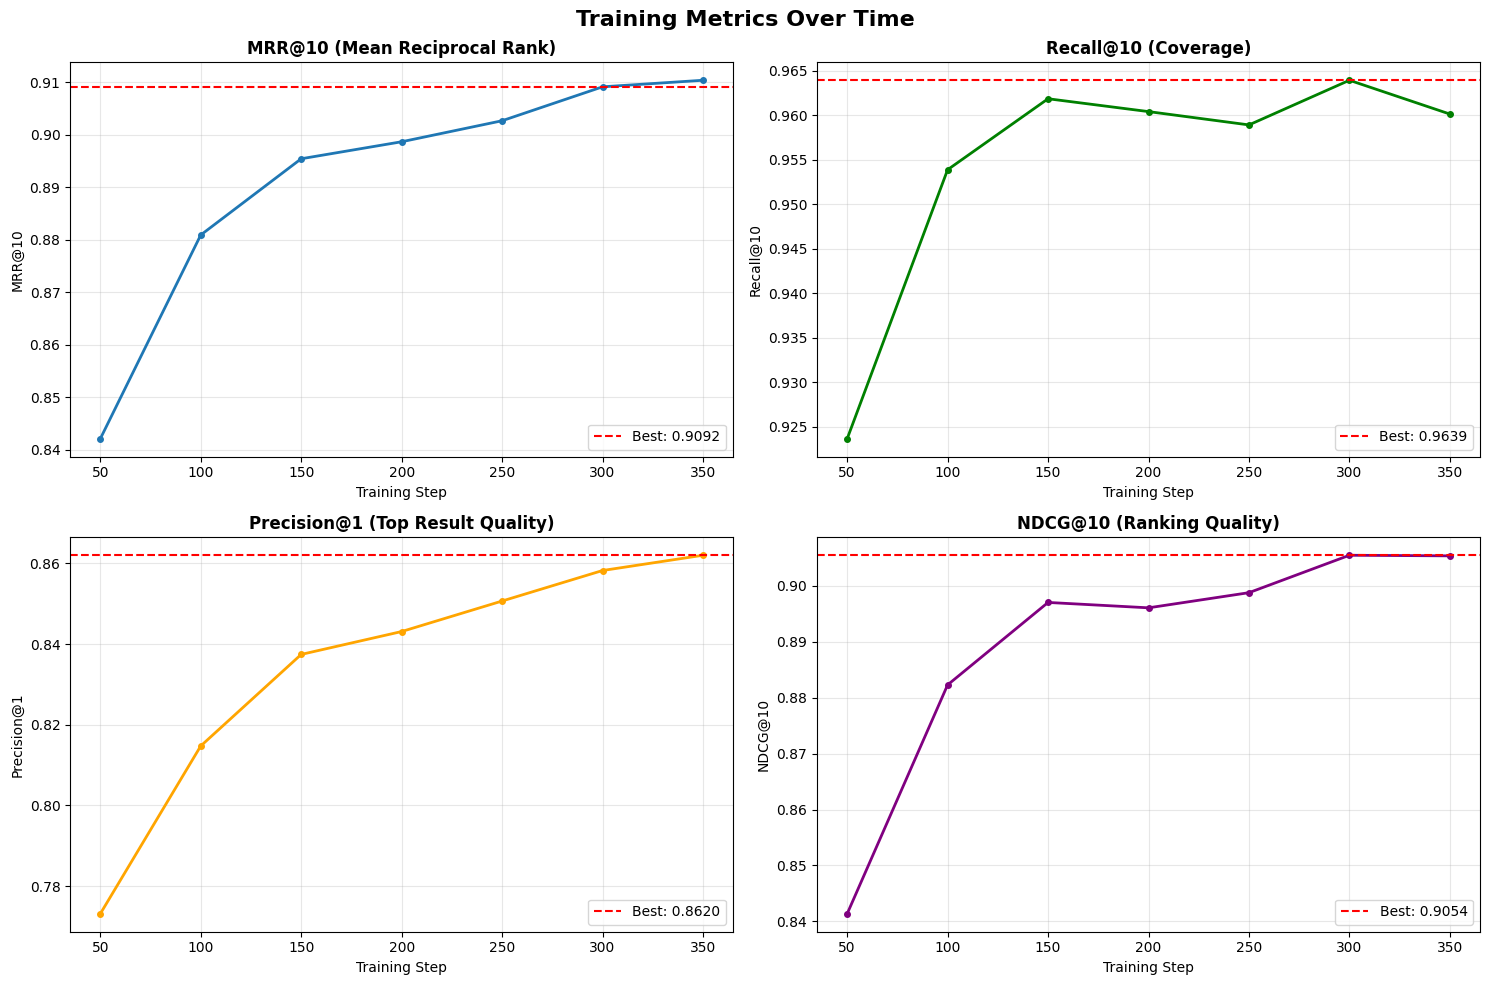


📊 Training Summary:

MRR@10:
   Initial: 0.8421
   Final:   0.9104
   Best:    0.9104
   Improvement: +8.1%
   ✅ Still improving (std: 0.006485)

Recall@10:
   Initial: 0.9236
   Final:   0.9601
   Best:    0.9639
   Improvement: +4.0%
   ✅ Still improving (std: 0.001922)

Precision@1:
   Initial: 0.7732
   Final:   0.8620
   Best:    0.8620
   Improvement: +11.5%
   ✅ Still improving (std: 0.010215)

NDCG@10:
   Initial: 0.8414
   Final:   0.9053
   Best:    0.9054
   Improvement: +7.6%
   ✅ Still improving (std: 0.004550)

💡 RECOMMENDATIONS:
   ✅ Early stopping worked correctly - training stopped at optimal point
   🎯 Best mrr@10: 0.9092


In [14]:
# 📊 Visualize Training Progress and Metrics
if early_stopping and early_stopping.evaluation_history:
    print("\n📈 Creating training visualization...")
    
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Load evaluation history
    df = pd.DataFrame(early_stopping.evaluation_history)
    
    print(f"✅ Loaded {len(df)} evaluation checkpoints")
    
    # Helper to find column name in df for a metric
    def find_col(df, target):
        target_lower = target.lower()
        cols = list(df.columns)
        if target in cols:
            return target
        for c in cols:
            try:
                if c.lower().endswith(target_lower):
                    return c
            except Exception:
                continue
        for c in cols:
            try:
                if target_lower in c.lower():
                    return c
            except Exception:
                continue
        return None
    
    # Map logical metric names to df columns
    mrr_col = find_col(df, 'mrr@10')
    recall_col = find_col(df, 'recall@10')
    p1_col = find_col(df, 'precision@1')
    ndcg_col = find_col(df, 'ndcg@10')
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Over Time', fontsize=16, fontweight='bold')
    
    # Plot 1: MRR@10
    if mrr_col and mrr_col in df.columns:
        axes[0, 0].plot(df['step'], df[mrr_col], marker='o', linewidth=2, markersize=4)
        axes[0, 0].set_title('MRR@10 (Mean Reciprocal Rank)', fontweight='bold')
        axes[0, 0].set_xlabel('Training Step')
        axes[0, 0].set_ylabel('MRR@10')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axhline(y=early_stopping.best_score, color='r', linestyle='--', label=f'Best: {early_stopping.best_score:.4f}')
        axes[0, 0].legend()
    else:
        axes[0, 0].text(0.5, 0.5, 'MRR@10 not found in history', ha='center')
    
    # Plot 2: Recall@10
    if recall_col and recall_col in df.columns:
        axes[0, 1].plot(df['step'], df[recall_col], marker='o', linewidth=2, markersize=4, color='green')
        axes[0, 1].set_title('Recall@10 (Coverage)', fontweight='bold')
        axes[0, 1].set_xlabel('Training Step')
        axes[0, 1].set_ylabel('Recall@10')
        axes[0, 1].grid(True, alpha=0.3)
        best_recall = df[recall_col].max()
        axes[0, 1].axhline(y=best_recall, color='r', linestyle='--', label=f'Best: {best_recall:.4f}')
        axes[0, 1].legend()
    else:
        axes[0, 1].text(0.5, 0.5, 'Recall@10 not found in history', ha='center')
    
    # Plot 3: Precision@1
    if p1_col and p1_col in df.columns:
        axes[1, 0].plot(df['step'], df[p1_col], marker='o', linewidth=2, markersize=4, color='orange')
        axes[1, 0].set_title('Precision@1 (Top Result Quality)', fontweight='bold')
        axes[1, 0].set_xlabel('Training Step')
        axes[1, 0].set_ylabel('Precision@1')
        axes[1, 0].grid(True, alpha=0.3)
        best_p1 = df[p1_col].max()
        axes[1, 0].axhline(y=best_p1, color='r', linestyle='--', label=f'Best: {best_p1:.4f}')
        axes[1, 0].legend()
    else:
        axes[1, 0].text(0.5, 0.5, 'Precision@1 not found in history', ha='center')
    
    # Plot 4: NDCG@10
    if ndcg_col and ndcg_col in df.columns:
        axes[1, 1].plot(df['step'], df[ndcg_col], marker='o', linewidth=2, markersize=4, color='purple')
        axes[1, 1].set_title('NDCG@10 (Ranking Quality)', fontweight='bold')
        axes[1, 1].set_xlabel('Training Step')
        axes[1, 1].set_ylabel('NDCG@10')
        axes[1, 1].grid(True, alpha=0.3)
        best_ndcg = df[ndcg_col].max()
        axes[1, 1].axhline(y=best_ndcg, color='r', linestyle='--', label=f'Best: {best_ndcg:.4f}')
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, 'NDCG@10 not found in history', ha='center')
    
    plt.tight_layout()
    
    # Save plot
    plot_path = output_dir / 'training_metrics.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"💾 Training visualization saved: {plot_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\n📊 Training Summary:")
    print("=" * 60)
    
    for col_name, friendly in [(mrr_col, 'MRR@10'), (recall_col, 'Recall@10'), (p1_col, 'Precision@1'), (ndcg_col, 'NDCG@10')]:
        if col_name and col_name in df.columns:
            initial = df[col_name].iloc[0]
            final = df[col_name].iloc[-1]
            best = df[col_name].max()
            improvement = ((final - initial) / initial * 100) if initial > 0 else 0
            
            print(f"\n{friendly}:")
            print(f"   Initial: {initial:.4f}")
            print(f"   Final:   {final:.4f}")
            print(f"   Best:    {best:.4f}")
            print(f"   Improvement: {improvement:+.1f}%")
            
            # Check for plateau
            last_5 = df[col_name].tail(5)
            if len(last_5) >= 5:
                std = last_5.std()
                if std < 0.001:
                    print(f"   ⚠️ Plateaued (std: {std:.6f})")
                else:
                    print(f"   ✅ Still improving (std: {std:.6f})")
else:
    print("⚠️ No evaluation history available - visualization skipped")

## 🧪 Model Testing

In [15]:
# 🧪 Model Testing and Analysis
if train_data and len(train_data) > 0:
    print("🧪 Quick Model Testing & Analysis")
    print("=" * 50)
    
    # Test with multiple samples for robust evaluation
    test_samples = train_data[:5]  # Test with first 5 samples
    
    all_pos_similarities = []
    all_neg_similarities = []
    
    for idx, test_sample in enumerate(test_samples):
        test_query = test_sample.get('query', '').strip()
        pos_test_skills = [skill.strip() for skill in test_sample.get('pos', []) if skill.strip()][:3]
        neg_test_skills = [skill.strip() for skill in test_sample.get('neg', []) if skill.strip()][:3]
        
        # Validate sample has required data
        if not test_query:
            print(f"\n⚠️ Test Sample {idx+1}: Empty query, skipping...")
            continue
            
        if not pos_test_skills:
            print(f"\n⚠️ Test Sample {idx+1}: No valid positive skills, skipping...")
            continue
            
        if not neg_test_skills:
            print(f"\n⚠️ Test Sample {idx+1}: No valid negative skills, skipping...")
            continue
        
        print(f"\n📝 Test Sample {idx+1}:")
        print(f"   Query: {test_query[:100]}{'...' if len(test_query) > 100 else ''}")
        print(f"   Positive skills: {len(pos_test_skills)}, Negative skills: {len(neg_test_skills)}")
        
        try:
            # Encode with E5 prefixes
            if CONFIG['use_e5_prefixes']:
                query_text = f"query: {test_query}"
                pos_skill_texts = [f"passage: {skill}" for skill in pos_test_skills]
                neg_skill_texts = [f"passage: {skill}" for skill in neg_test_skills]
            else:
                query_text = test_query
                pos_skill_texts = pos_test_skills
                neg_skill_texts = neg_test_skills
            
            # Encode and validate embeddings
            query_embedding = model.encode([query_text])
            pos_skill_embeddings = model.encode(pos_skill_texts)
            neg_skill_embeddings = model.encode(neg_skill_texts)
            
            # Validate embedding shapes
            if query_embedding.shape[0] == 0:
                print(f"   ❌ Empty query embedding, skipping...")
                continue
            if pos_skill_embeddings.shape[0] == 0:
                print(f"   ❌ Empty positive skill embeddings, skipping...")
                continue
            if neg_skill_embeddings.shape[0] == 0:
                print(f"   ❌ Empty negative skill embeddings, skipping...")
                continue
            
            print(f"   📐 Embedding shapes: query{query_embedding.shape}, pos{pos_skill_embeddings.shape}, neg{neg_skill_embeddings.shape}")
            
            # Compute similarities
            pos_similarities = model.similarity(query_embedding, pos_skill_embeddings)[0]
            neg_similarities = model.similarity(query_embedding, neg_skill_embeddings)[0]
            
            # Store for overall analysis
            all_pos_similarities.extend(pos_similarities.tolist())
            all_neg_similarities.extend(neg_similarities.tolist())
            
            print(f"   📊 Positive skills (should be high similarity):")
            for i, (skill, score) in enumerate(zip(pos_test_skills, pos_similarities)):
                print(f"      {score:.4f} - {skill[:80]}{'...' if len(skill) > 80 else ''}")
            
            print(f"   📊 Negative skills (should be low similarity):")
            for i, (skill, score) in enumerate(zip(neg_test_skills, neg_similarities)):
                print(f"      {score:.4f} - {skill[:80]}{'...' if len(skill) > 80 else ''}")
                
        except Exception as e:
            print(f"   ❌ Error processing sample {idx+1}: {str(e)}")
            print(f"   🔍 Query length: {len(test_query)}")
            print(f"   🔍 Pos skills: {len(pos_test_skills)} items")
            print(f"   🔍 Neg skills: {len(neg_test_skills)} items")
            continue
    
    # Overall performance analysis
    print(f"\n📈 OVERALL PERFORMANCE ANALYSIS:")
    print(f"=" * 40)
    
    if not all_pos_similarities or not all_neg_similarities:
        print("❌ No valid similarities computed!")
        print(f"   Positive similarities: {len(all_pos_similarities)}")
        print(f"   Negative similarities: {len(all_neg_similarities)}")
    else:
        import numpy as np
        
        pos_mean = np.mean(all_pos_similarities)
        pos_std = np.std(all_pos_similarities)
        neg_mean = np.mean(all_neg_similarities)
        neg_std = np.std(all_neg_similarities)
        
        separation = pos_mean - neg_mean
        
        print(f"✅ Positive similarities: {pos_mean:.4f} ± {pos_std:.4f}")
        print(f"❌ Negative similarities: {neg_mean:.4f} ± {neg_std:.4f}")
        print(f"📏 Separation (higher is better): {separation:.4f}")
        
        # Quality assessment
        if separation > 0.2:
            quality = "🌟 Excellent"
        elif separation > 0.1:
            quality = "✅ Good"
        elif separation > 0.05:
            quality = "⚠️ Fair"
        else:
            quality = "❌ Poor"
        
        print(f"🎯 Model Quality: {quality}")
        
        # Ranking test
        print(f"\n🏆 RANKING TEST:")
        print(f"Testing if positive skills rank higher than negative skills...")
        
        correct_rankings = 0
        total_comparisons = 0
        
        for i in range(len(all_pos_similarities)):
            for j in range(len(all_neg_similarities)):
                if all_pos_similarities[i] > all_neg_similarities[j]:
                    correct_rankings += 1
                total_comparisons += 1
        
        ranking_accuracy = correct_rankings / total_comparisons if total_comparisons > 0 else 0
        print(f"🎯 Ranking Accuracy: {ranking_accuracy:.3f} ({correct_rankings}/{total_comparisons})")
        
        if ranking_accuracy > 0.8:
            ranking_quality = "🌟 Excellent"
        elif ranking_accuracy > 0.7:
            ranking_quality = "✅ Good"
        elif ranking_accuracy > 0.6:
            ranking_quality = "⚠️ Fair"
        else:
            ranking_quality = "❌ Poor"
        
        print(f"🏆 Ranking Quality: {ranking_quality}")
    
else:
    print("❌ No test data available")

🧪 Comprehensive Model Testing & Analysis

📝 Test Sample 1:
   Query: bestehende Texte präzise umzuformulieren, um Lesbarkeit und Zielgruppenansprache zu optimieren sowie...
   Positive skills: 1, Negative skills: 3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   📐 Embedding shapes: query(1, 768), pos(1, 768), neg(3, 768)
   📊 Positive skills (should be high similarity):
      0.5994 - Artikel umschreiben: Umschreiben von Artikeln, um Fehler zu korrigieren, die Art...
   📊 Negative skills (should be low similarity):
      -0.0664 - Büroausstattung aufstellen und einrichten: Anschließen verschiedener Bürogeräte ...
      0.5939 - Grammatik- und Rechtschreibregeln anwenden: Beachtung der Rechtschreib- und Gram...
      0.6170 - schriftliche Inhalte zur Verfügung stellen: Übermittlung schriftlicher Informati...

📝 Test Sample 2:
   Query: Stärken Sie Ihre Systematik: Lernen Sie, Daten nach Kriterien wie Datum, Priorität oder Kategorie zu...
   Positive skills: 1, Negative skills: 3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   📐 Embedding shapes: query(1, 768), pos(1, 768), neg(3, 768)
   📊 Positive skills (should be high similarity):
      0.6333 - Informationen ordnen: Ordnen von Informationen nach bestimmten Regeln. Katalogis...
   📊 Negative skills (should be low similarity):
      -0.1408 - Kraftfahrzeugmechanik: Die Art und Weise, wie Energie-Kräfte interagieren und Ko...
      -0.0255 - Streichinstrumente stimmen: Stimmen aller Teile von Streichinstrumenten, die sch...
      0.5763 - Klassifizierungssysteme entwickeln: Organisieren von Archiven oder Geschäftsunte...

📝 Test Sample 3:
   Query: Digitales Arbeiten im Büro im Microsoft 365 Microsoft 365 Bürokommunikation Büroorganisation Berufli...
   Positive skills: 3, Negative skills: 3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   📐 Embedding shapes: query(1, 768), pos(3, 768), neg(3, 768)
   📊 Positive skills (should be high similarity):
      0.5358 - Cloud-Technologien: Technologien, die den Zugang zu Hardware, Software, Daten un...
      0.4888 - Online-Tools zur Zusammenarbeit verwenden: Nutzung von Online-Ressourcen, z. B. ...
      0.5299 - Kommunikations- und Kollaborationssoftware verwenden: Nutzen einfacher digitaler...
   📊 Negative skills (should be low similarity):
      0.4066 - Bürosysteme nutzen: Angemessene und zeitgemäße Nutzung von Bürosystemen, die in ...
      0.4472 - Bürosysteme verwalten: Verwalten und Warten der verschiedenen Bürosysteme, die f...
      0.3841 - Bürosoftware: Merkmale und Funktionsweise von Softwareprogrammen für Büroaufgabe...

📝 Test Sample 4:
   Query: Es wird gelerntdigitale Buchungs- und Check-in-Tools für Reisen sicher anzuwenden und Kunden bei der...
   Positive skills: 1, Negative skills: 3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   📐 Embedding shapes: query(1, 768), pos(1, 768), neg(3, 768)
   📊 Positive skills (should be high similarity):
      0.6311 - Selbstbedienungstechnologien im Tourismus: Die Anwendung von Selbstbedienungstec...
   📊 Negative skills (should be low similarity):
      0.0397 - Krisenintervention: Bewältigungsstrategien in Krisensituationen, die es den Einz...
      0.0376 - Prince2-Projektmanagement: Das PRINCE2-Management ist eine Methodik für die Plan...
      0.4566 - Buchungen bearbeiten: Ausführung einer Buchung eines Ortes im Voraus entsprechen...

📝 Test Sample 5:
   Query: Beim Praxisprojekt fiel mir auf, dass ich durch gezieltes Riechen und Kosten der Walnussöl-Charge kl...
   Positive skills: 1, Negative skills: 3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   📐 Embedding shapes: query(1, 768), pos(1, 768), neg(3, 768)
   📊 Positive skills (should be high similarity):
      0.5414 - sensorische Parameter von Ölen und Fetten kontrollieren: Kontrollieren der senso...
   📊 Negative skills (should be low similarity):
      0.0518 - Lernbedarfsanalyse: Prozess der Analyse des Lernbedarfs eines Lernenden durch Be...
      -0.0494 - Netiquette beachten: Anwenden von Verhaltensnormen und Wissen bei der Nutzung di...
      0.3936 - Dichte von Flüssigkeiten messen: Messen der Dichte von Flüssigkeiten, einschließ...

📈 OVERALL PERFORMANCE ANALYSIS:
✅ Positive similarities: 0.5657 ± 0.0516
❌ Negative similarities: 0.2482 ± 0.2647
📏 Separation (higher is better): 0.3175
🎯 Model Quality: 🌟 Excellent

🏆 RANKING TEST:
Testing if positive skills rank higher than negative skills...
🎯 Ranking Accuracy: 0.876 (92/105)
🏆 Ranking Quality: 🌟 Excellent

💡 RECOMMENDATIONS:


## 📦 Model Download Package

In [16]:
# 📦 Create downloadable model package
if output_dir.exists():
    print("📦 Creating download package...")
    
    # Create zip file
    filename = f"finetuned_esco_model_{timestamp}.zip"
    zip_filename = f"/kaggle/working/{filename}"
    
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Add all model files, but exclude checkpoints and temporary files
        for root, dirs, files in os.walk(output_dir):
            # Skip checkpoint directories and logs
            dirs[:] = [d for d in dirs if not d.startswith('checkpoint-') and d != 'logs']
            
            for file in files:
                # Skip large optimizer/trainer files (they're not needed for inference)
                if file in ['optimizer.pt', 'scheduler.pt', 'trainer_state.json', 'training_args.bin']:
                    continue
                    
                file_path = Path(root) / file
                # Create relative path for zip
                arcname = file_path.relative_to(output_dir)
                zipf.write(file_path, arcname)
                print(f"   Adding: {arcname}")
        
        # Add usage instructions
        usage_info = f"""# Fine-tuned ESCO Skill Retrieval Model

## Usage

```python
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('path/to/extracted/model')

# Use with E5 prefixes
query_embedding = model.encode(['query: your search text'])
skill_embeddings = model.encode(['passage: skill 1', 'passage: skill 2'])

# Compute similarities
similarities = model.similarity(query_embedding, skill_embeddings)
```

## Training Details

- Base Model: {MODEL_NAME}
- Training Samples: {len(examples) if 'examples' in globals() else 'N/A'}
- Epochs: {CONFIG['epochs']}
- Batch Size: {CONFIG['batch_size']}
- Learning Rate: {CONFIG['learning_rate']}
- Training Date: {datetime.now().isoformat()}
- Further details: {training_details if 'training_details' in globals() else 'N/A'}

## Important

"""
        
        # Add E5 prefix information if enabled
        if CONFIG['use_e5_prefixes']:
            usage_info += "- Always use E5 prefixes: 'query:' for queries, 'passage:' for documents\n"
        
        usage_info += f"""- Max sequence length: {model.max_seq_length if 'model' in globals() else 512}

"""
        
        # Add README to zip
        from io import StringIO
        zipf.writestr('README.md', usage_info)
    
    # Check file size
    file_size = Path(zip_filename).stat().st_size / 1e6  # MB
    
    
    print(f"\n✅ Download package created!")
    print(f"📁 File: {zip_filename}")
    print(f"📊 Size: {file_size:.1f} MB")
    print(f"💡 Checkpoint directories excluded - only best model included!")
    
else:
    print("❌ No trained model found to package")


📦 Creating download package...
   Adding: README.md
   Adding: training_log.json
   Adding: special_tokens_map.json
   Adding: sentence_bert_config.json
   Adding: config.json
   Adding: tokenizer_config.json
   Adding: Information-Retrieval_evaluation_esco_curriculum_results.csv
   Adding: tokenizer.json
   Adding: config_sentence_transformers.json
   Adding: training_metrics.png
   Adding: sentencepiece.bpe.model
   Adding: modules.json
   Adding: model.safetensors
   Adding: evaluation_metrics.csv
   Adding: best_model/README.md
   Adding: best_model/special_tokens_map.json
   Adding: best_model/sentence_bert_config.json
   Adding: best_model/config.json
   Adding: best_model/tokenizer_config.json
   Adding: best_model/tokenizer.json
   Adding: best_model/config_sentence_transformers.json
   Adding: best_model/sentencepiece.bpe.model
   Adding: best_model/modules.json
   Adding: best_model/model.safetensors
   Adding: best_model/1_Pooling/config.json
   Adding: 1_Pooling/config.json

In [3]:
# Create download link
from IPython.display import FileLink
FileLink(filename)

/kaggle/working/finetuned_esco_model_202759.zip